In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Activation, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2DTranspose, Lambda
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import os
from numpy import genfromtxt

Using TensorFlow backend.


In [2]:
def read_ecg(file_name):
    return genfromtxt(file_name, delimiter=',')

In [3]:
np_data = read_ecg('./input/clean_ecg3.csv')
np_data2 = read_ecg('./input/noise_ecg3.csv')

In [4]:
split_percent = 0.8

x_train = np_data[0 : int((np_data.shape[0]) * split_percent)]
x_test = np_data[int(np_data.shape[0] * split_percent): ]


xtrainn = np_data2[0 : int((np_data2.shape[0]) * split_percent)]
xtestn = np_data2[int(np_data2.shape[0] * split_percent): ]


print(x_train.shape)
print(xtrainn.shape)
print(x_test.shape)
print(xtestn.shape)


(6086, 1024)
(6086, 1024)
(1522, 1024)
(1522, 1024)


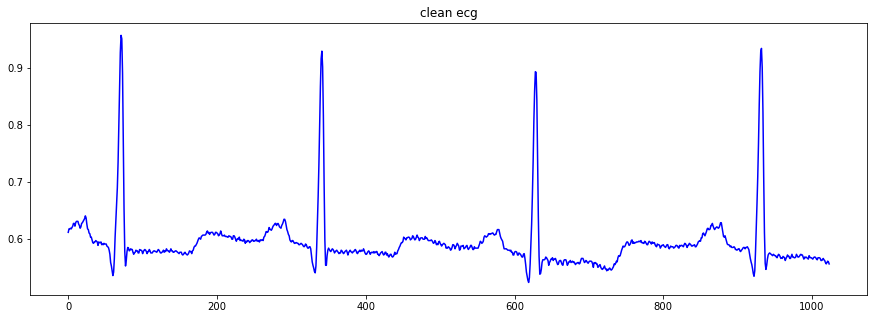

In [5]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_train[1000], 'b')
plt.title("clean ecg")
plt.show()

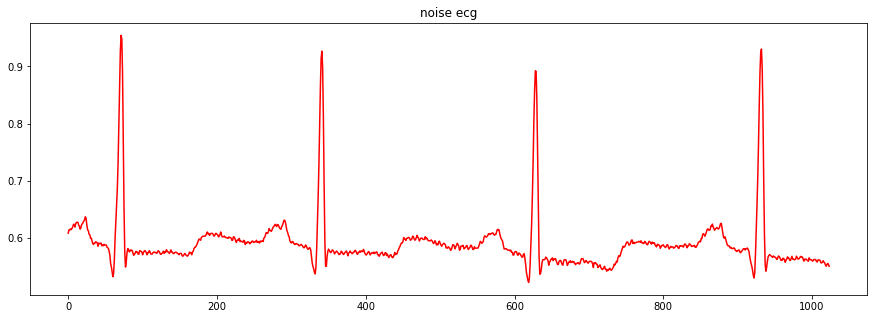

In [6]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(xtrainn[1000], 'r')
plt.title("noise ecg")
plt.show()

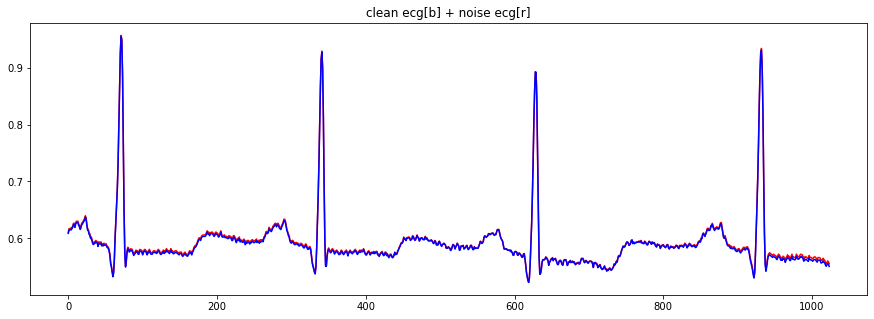

In [7]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_train[1000], 'r')
ax.plot(xtrainn[1000], 'b')
plt.title("clean ecg[b] + noise ecg[r]")
plt.show()

In [8]:
x_train_noisy = np.asarray(xtrainn)
x_test_noisy = np.asarray(xtestn)

In [9]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)



In [10]:
x_train = normalized(x_train,1)
x_test = normalized(x_test,1)
x_train_noisy = normalized(x_train_noisy,1)
x_test_noisy = normalized(x_test_noisy, 1)

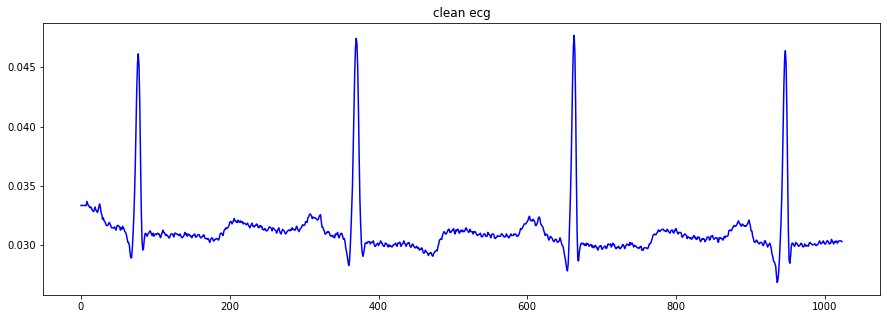

In [11]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_train[0], 'b')
plt.title("clean ecg")
plt.show()

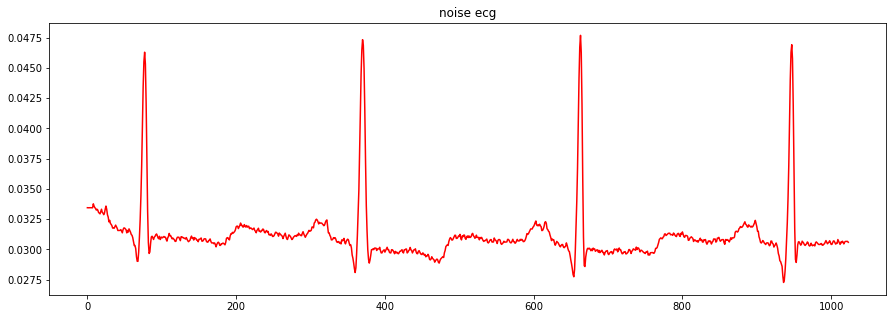

In [12]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_train_noisy[0], 'r')
plt.title("noise ecg")
plt.show()

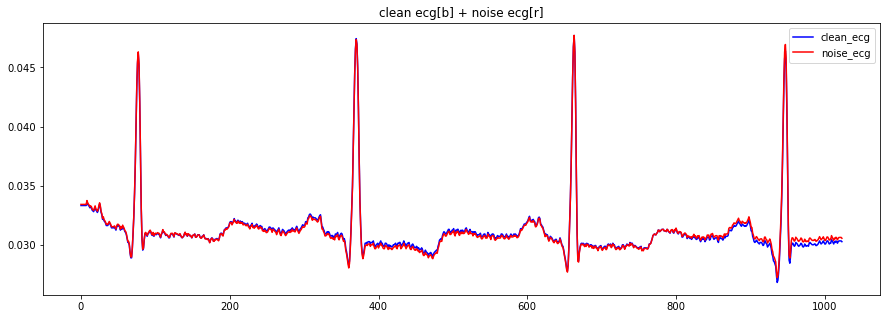

In [13]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_train[0], 'b',label='clean_ecg')
ax.plot(x_train_noisy[0], 'r',label='noise_ecg')
plt.title("clean ecg[b] + noise ecg[r]")
plt.legend()
plt.show()

In [14]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_noisy = x_train_noisy.reshape((x_train_noisy.shape[0],x_train_noisy.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
x_test_noisy = x_test_noisy.reshape((x_test_noisy.shape[0],x_test_noisy.shape[1],1))


In [15]:
print(x_train.shape)
print(x_train_noisy.shape)
print(x_test.shape)
print(x_test_noisy.shape)

(6086, 1024, 1)
(6086, 1024, 1)
(1522, 1024, 1)
(1522, 1024, 1)


In [16]:
a = x_train[0]
a

array([[0.0333481 ],
       [0.0333481 ],
       [0.0333481 ],
       ...,
       [0.03036364],
       [0.03036364],
       [0.03029876]])

In [17]:
b = x_train_noisy[0]
b

array([[0.0334441 ],
       [0.03343797],
       [0.03344206],
       ...,
       [0.03065811],
       [0.03065811],
       [0.03058463]])

In [18]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    """
        https://stackoverflow.com/a/45788699

        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x


In [19]:
input_img = Input(shape=(x_train.shape[1],1))


x = Conv1D(filters=40,kernel_size=16,activation='elu',strides=2,padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv1D(filters=20, kernel_size=16,activation='relu',strides=2,padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=20, kernel_size=16,activation='elu',strides=2,padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=20, kernel_size=16,activation='elu',strides=2,padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=40, kernel_size=16,activation='elu',strides=2,padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=1, kernel_size=16,activation='elu',strides=1,padding='same')(x)
x = BatchNormalization()(x)


x = Conv1DTranspose(input_tensor=x, filters=1,kernel_size=16, activation='elu',strides=1,padding='same')
x = BatchNormalization()(x)
x = Conv1DTranspose(input_tensor=x,filters=40,kernel_size=16,activation='elu',strides=2,padding='same')
x = BatchNormalization()(x)
x = Conv1DTranspose(input_tensor=x,filters=20,kernel_size=16,activation='elu',strides=2,padding='same')
x = BatchNormalization()(x)
x = Conv1DTranspose(input_tensor=x,filters=20,kernel_size=16,activation='elu',strides=2, padding='same')
x = BatchNormalization()(x)
x = Conv1DTranspose(input_tensor=x,filters=20,kernel_size=16,activation='elu',strides=2,padding='same')
x = BatchNormalization()(x)
x = Conv1DTranspose(input_tensor=x,filters=40,kernel_size=16,activation='elu',strides=2, padding='same')
x = BatchNormalization()(x)
x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=16,activation='sigmoid',strides=1,padding='same')

autoencoder = Model(input_img, x)
print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 40)           680       
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 40)           160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 20)           12820     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 20)           80        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 20)           6420      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 20)           80  

In [20]:
from keras.optimizers import *

#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-5),


autoencoder.compile(optimizer= Adam(lr=0.001),                    
                               loss='mse')
                               #metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = autoencoder.fit(x_train_noisy, x_train,
    epochs = 1000,
    batch_size = 32,
    shuffle = True,
    #validation_split=0.2,
    validation_data=(x_test_noisy, x_test),
    callbacks=[es])

Train on 6086 samples, validate on 1522 samples
Epoch 1/1000
6086/6086 [==============================] - 7s 1ms/step - loss: 0.0350 - val_loss: 2.6043e-05
Epoch 2/1000
6086/6086 [==============================] - 4s 690us/step - loss: 2.7276e-05 - val_loss: 1.7328e-05
Epoch 3/1000
6086/6086 [==============================] - 4s 682us/step - loss: 1.2002e-05 - val_loss: 1.2427e-05
Epoch 4/1000
6086/6086 [==============================] - 4s 681us/step - loss: 9.8654e-06 - val_loss: 9.1391e-06
Epoch 5/1000
6086/6086 [==============================] - 4s 681us/step - loss: 8.5630e-06 - val_loss: 8.1881e-06
Epoch 6/1000
6086/6086 [==============================] - 4s 685us/step - loss: 7.5990e-06 - val_loss: 7.3018e-06
Epoch 7/1000
6086/6086 [==============================] - 4s 687us/step - loss: 6.8661e-06 - val_loss: 6.5974e-06
Epoch 8/1000
6086/6086 [==============================] - 4s 689us/step - loss: 6.2496e-06 - val_loss: 6.2740e-06
Epoch 9/1000
6086/6086 [======================

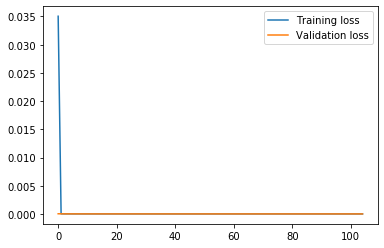

In [22]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()

In [23]:
# plt.plot(history.history["accuracy"], label="Training acc")
# plt.plot(history.history["val_accuracy"], label="Validation acc")
# plt.legend()

In [24]:
decoded_imgs = autoencoder.predict(x_test_noisy)
decoded_imgs.shape

(1522, 1024, 1)

In [25]:
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0],
                                      x_train_noisy.shape[1])

decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],
                                    decoded_imgs.shape[1])

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])

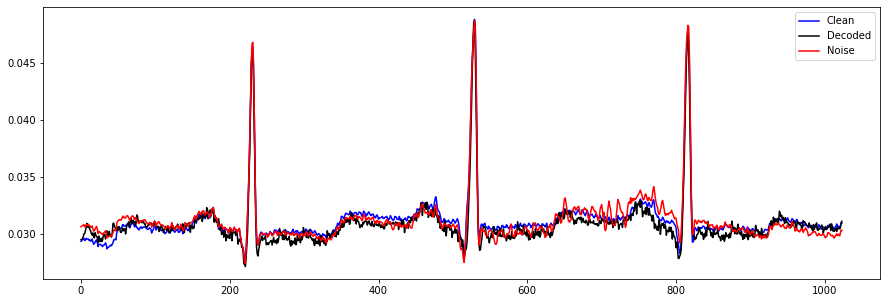

In [34]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test[300], 'b', label='Clean')
ax.plot(decoded_imgs[300], 'k', label='Decoded')   
ax.plot(x_test_noisy[300], 'r', label='Noise')
plt.legend()
plt.show()

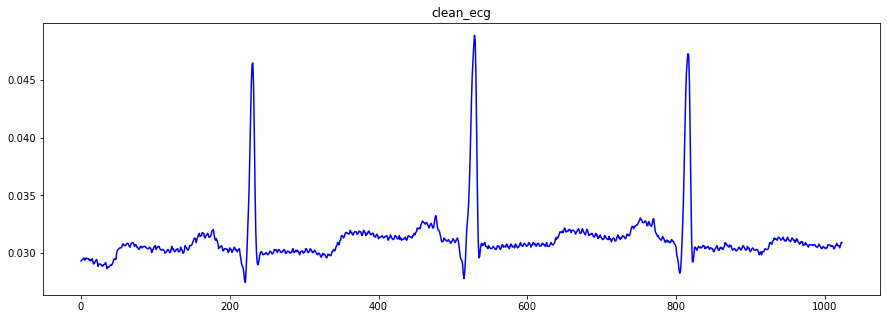

In [35]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test[300], 'b')
plt.title('clean_ecg')
plt.show()

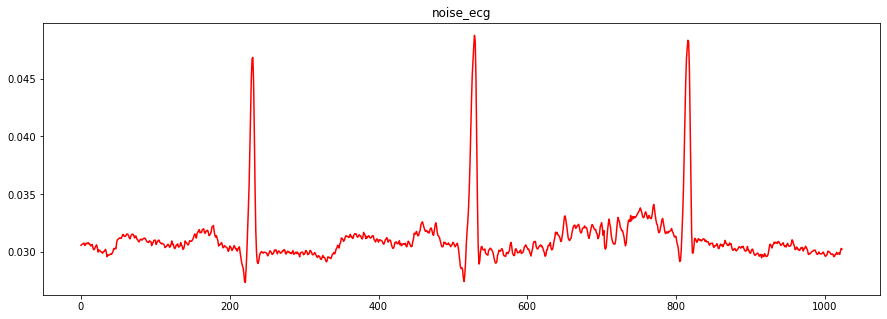

In [36]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test_noisy[300], 'r')
plt.title('noise_ecg')
plt.show()

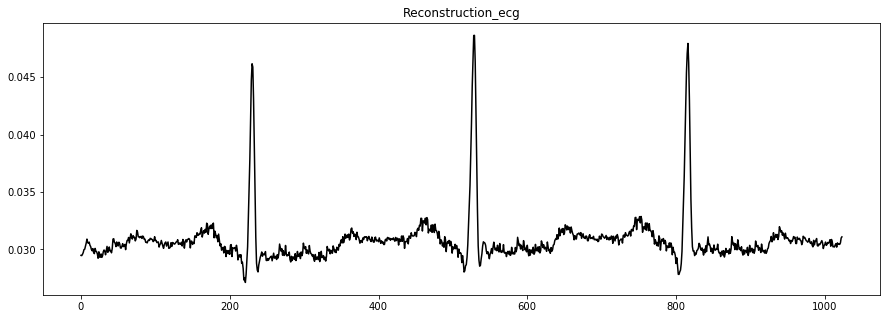

In [37]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(decoded_imgs[300], 'k')   
plt.title('Reconstruction_ecg')
plt.show()

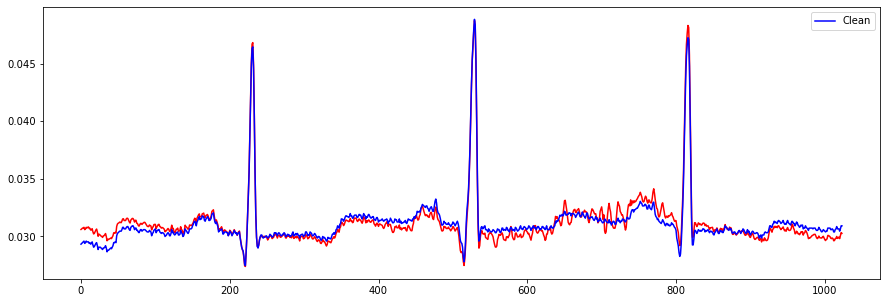

In [42]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test_noisy[300], 'r')
ax.plot(x_test[300], 'b', label='Clean')
plt.legend()
plt.show()

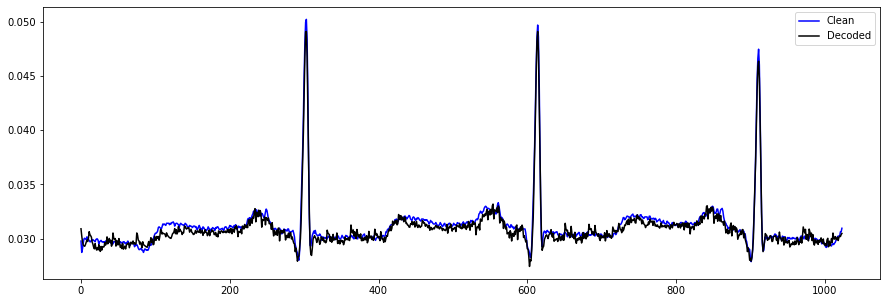

In [43]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test[50], 'b', label='Clean')
ax.plot(decoded_imgs[50], 'k', label='Decoded')   
plt.legend()
plt.show()

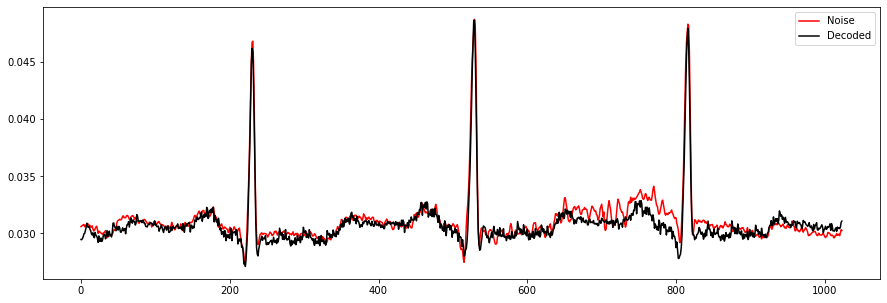

In [46]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(x_test_noisy[300], 'r', label='Noise')
ax.plot(decoded_imgs[300], 'k', label='Decoded')   
plt.legend()
plt.show()